In [7]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from ibgest.estimation import iterative_background_estimate
from ibgest.config import set_logging_level

set_logging_level("DEBUG")

%load_ext autoreload
%autoreload 2

2024-09-20 09:52:24,981 - ibgest - INFO - Logging level set to DEBUG


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


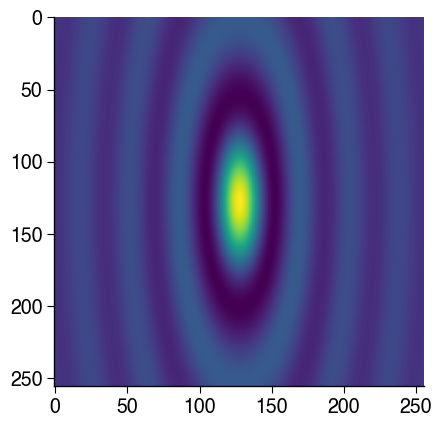

In [21]:
Ny, Nx = 256, 256
fy, fx = np.fft.fftfreq(Ny), np.fft.fftfreq(Nx)
ky, kx = np.meshgrid(fy, fx, indexing="ij")
wy = 5
wx = 15
r = np.sqrt((wy * ky) ** 2 + (wx * kx) ** 2)
H2d = np.sinc(r)
plt.imshow(np.fft.fftshift(H2d))


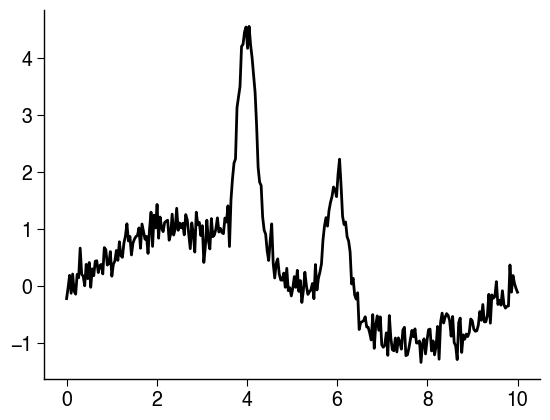

In [2]:
# make synthetic data
x = np.linspace(0, 10, num=300)
background_signal = np.sin(2 * np.pi * x / 10)
white_noise = np.random.randn(x.size) * 0.2
spike1 = 4.0 * np.exp(-(x-4.0)**2/(2 * 0.2 ** 2))
spike2 = 2.5 * np.exp(-(x-6.0)**2/(2 * 0.25 ** 2))
y = background_signal + white_noise + spike1 + spike2

plt.plot(x, y, 'k-')

In [10]:
res = iterative_background_estimate(y.astype(np.float32), 4.0, max_iter=100)

2024-09-20 09:53:02,173 - ibgest - INFO - Using device: mps
2024-09-20 09:53:02,356 - ibgest - DEBUG - Iteration 1, relative change = 5.5147E-02
2024-09-20 09:53:02,516 - ibgest - DEBUG - Iteration 2, relative change = 5.5003E-02
2024-09-20 09:53:02,677 - ibgest - DEBUG - Iteration 3, relative change = 5.2626E-02
2024-09-20 09:53:02,832 - ibgest - DEBUG - Iteration 4, relative change = 4.5833E-02
2024-09-20 09:53:02,997 - ibgest - DEBUG - Iteration 5, relative change = 3.7928E-02
2024-09-20 09:53:03,001 - ibgest - DEBUG - Iteration 6, relative change = 3.1414E-02
2024-09-20 09:53:03,162 - ibgest - DEBUG - Iteration 7, relative change = 2.6617E-02
2024-09-20 09:53:03,165 - ibgest - DEBUG - Iteration 8, relative change = 2.3807E-02
2024-09-20 09:53:03,169 - ibgest - DEBUG - Iteration 9, relative change = 2.2853E-02
2024-09-20 09:53:03,174 - ibgest - DEBUG - Iteration 10, relative change = 2.2916E-02
2024-09-20 09:53:03,178 - ibgest - DEBUG - Iteration 11, relative change = 2.3046E-02
202

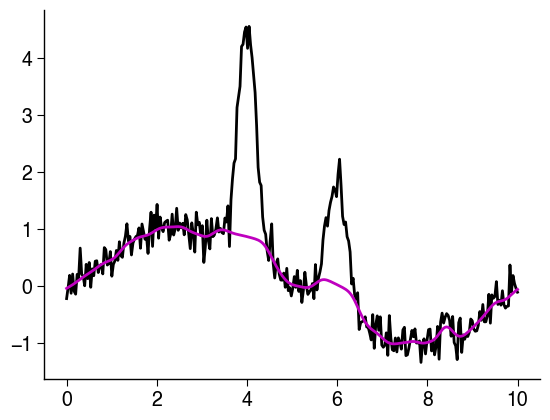

In [12]:
plt.plot(x, y, 'k-')
plt.plot(x, res, 'm-')

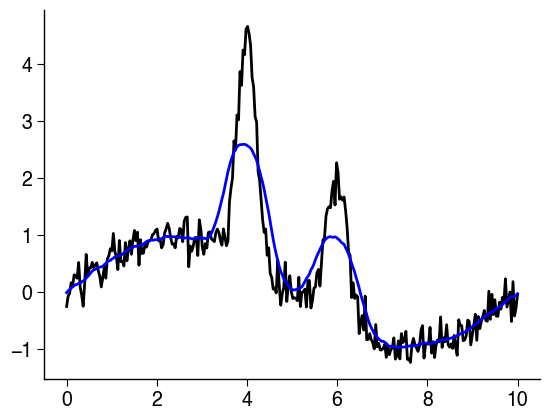

In [23]:
# uniform filter
w = 30
f = np.fft.rfftfreq(x.size)
H = np.sinc(w * f)
ft_y = np.fft.rfft(y)
blur = np.fft.irfft(ft_y * H, n=x.size)

plt.plot(x, y, 'k-')
plt.plot(x, blur, 'b-')

In [24]:
# compute arPLS weight
resid = y - blur
neg_mean = resid[resid < 0].mean()
neg_std = resid[resid < 0].std()
center = - neg_mean + 2 * neg_std
weights = 1/(1 + np.exp(2 * (resid - center) / neg_std))

estimate = blur + weights * resid

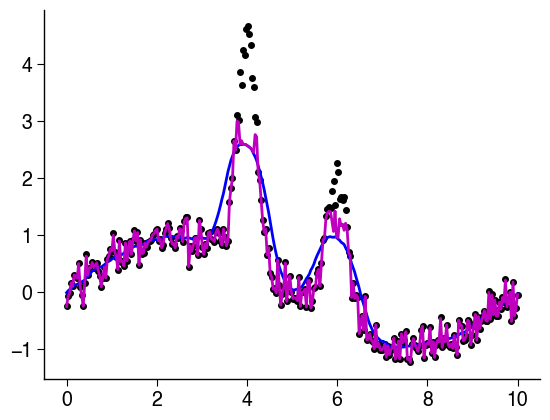

In [25]:
plt.plot(x, y, 'k.')
plt.plot(x, blur, 'b-')
plt.plot(x, estimate, 'm-')

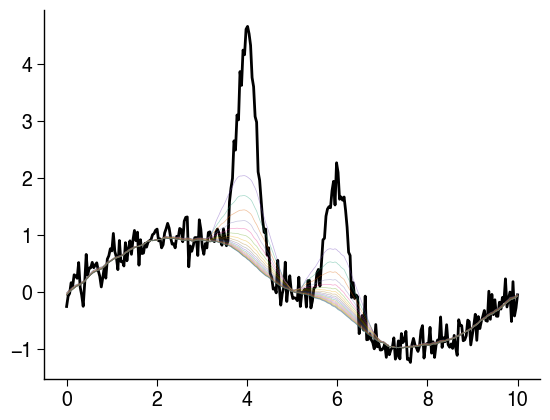

In [26]:
# for iterative procedure
max_iter = 20
estimate = y.copy()

fig, ax = plt.subplots()

ax.plot(x, y, 'k-')

# initial blur
ft_estimate = np.fft.rfft(estimate)
estimate = np.fft.irfft(ft_estimate * H, n=x.size)

for k in range(max_iter):
    # compute weights
    resid = y - estimate
    neg_mean = resid[resid<0].mean()
    neg_std = resid[resid<0].std()
    center = -neg_mean + 2 * neg_std
    weights = 1/(1 + np.exp(2 * (resid - center) / neg_std))
    estimate = estimate + weights * resid
    ft_estimate = np.fft.rfft(estimate)
    estimate = np.fft.irfft(ft_estimate * H, n=x.size)
    
    ax.plot(x, estimate, '-', lw=0.5, alpha=0.4)

    